# Réalisez une application mobile de recommandation de contenu

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

CLICK_THRESHOLD = 10
VAL_SIZE = .2

## Exploration des données

In [2]:
PATH_ARTICLES_DATA = "./data/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)
articles_df = articles_df[["article_id", "category_id", "words_count"]]
# articles_df["article_id"].is_unique => True
articles_df = articles_df.set_index("article_id")

In [3]:
articles_df.head()

,category_id,words_count
article_id,,
0,0,168
1,1,189
2,1,250
3,1,230
4,1,162


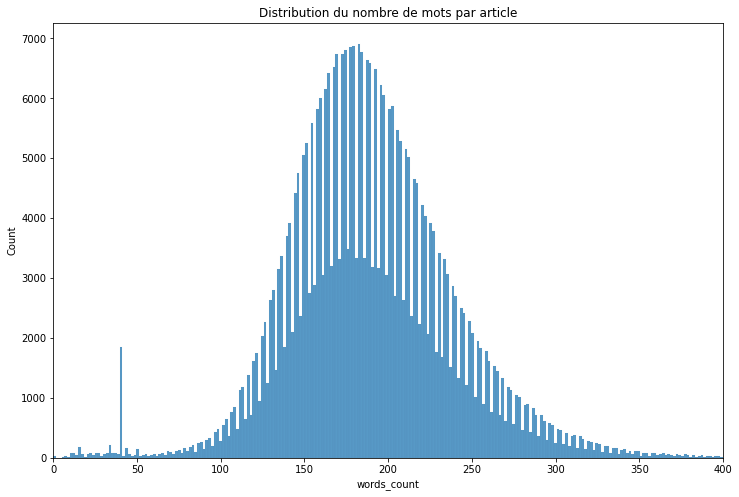

In [4]:
articles_df['words_count'].describe()
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(articles_df['words_count'],  ax=ax)
plt.xlim([0,400])
plt.title('Distribution du nombre de mots par article');
plt.show()

In [5]:
PREPROCESS = False

df_file = f'./clicks_df.csv'

if not os.path.isfile(df_file) or PREPROCESS:
    CLICK_FILES_PATH = "./data/clicks/"
    click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];
    click_files.sort()

    clicks_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];
    clicks_df = [x.drop(columns = ['session_id',
                                   'session_start',
                                   'session_size',
                                   'click_timestamp',
                                   'click_environment',
                                   'click_deviceGroup',
                                   'click_os',
                                   'click_country',
                                   'click_region',
                                   'click_referrer_type']) for x in clicks_df]
    clicks_df = pd.concat(clicks_df, axis=0, ignore_index=True)

    article_to_category = articles_df['category_id'].to_dict()
    clicks_df['category_id'] = clicks_df['click_article_id'].map(article_to_category).astype(int)

    clicks_df['total_click'] = clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
    clicks_df['total_click_by_category_id'] = clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
    clicks_df['category_click_rate'] = clicks_df['total_click_by_category_id'] / clicks_df['total_click']
    clicks_df = clicks_df.drop(["total_click", "total_click_by_category_id"], axis=1)

    clicks_df.to_csv(df_file, index=False)

    print(f'Shape after dropping duplicate : {clicks_df.shape}')

else:
    clicks_df = pd.read_csv(df_file)
    
clicks_df.head()

,user_id,click_article_id,category_id,category_click_rate
0,0,157541,281,0.250000
1,0,68866,136,0.125000
2,1,235840,375,0.166667
3,1,96663,209,0.083333
4,2,119592,247,0.250000


In [6]:
old_users = clicks_df.user_id.nunique()
old_shape = clicks_df.shape[0]
clicks_df = clicks_df[clicks_df['user_id'].isin(clicks_df['user_id'].value_counts()[clicks_df['user_id'].value_counts()>CLICK_THRESHOLD].index)]
new_users = clicks_df.user_id.nunique()
print(f"Suppression de {old_users - new_users} utilisateurs (moins de {CLICK_THRESHOLD} visites)")
print(f"{new_users} utilisateurs restants")
print(f"La taille de l'historique est passée de {old_shape} à {clicks_df.shape[0]}")

Suppression de 245606 utilisateurs (moins de 10 visites)
77291 utilisateurs restants
La taille de l'historique est passée de 2988181 à 1979922


In [7]:
#users = list(set(clicks_df["user_id"].to_list()))
#val_df_ids = random.sample(users, int(VAL_SIZE * len(users)))
#train_df = clicks_df[~clicks_df.user_id.isin(val_df_ids)]
#val_df = clicks_df[clicks_df.user_id.isin(val_df_ids)]

## SVD

In [8]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [9]:
reader = Reader(rating_scale=(0, 1))
# clicks_df = clicks_df[clicks_df['user_id'] < 42000]
clicks_ds = Dataset.load_from_df(clicks_df[['user_id', 'click_article_id', 'category_click_rate']], reader)
train_set, test_set = train_test_split(clicks_ds, test_size=VAL_SIZE)

In [10]:
%%time
model = SVD().fit(train_set)

Wall time: 1min 17s


In [11]:
predict = model.test(test_set)

In [12]:
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict)

RMSE: 0.0940
MSE: 0.0088
MAE:  0.0637


0.063699342158363

In [13]:
print(f'Prediction rating for User 0 with cat 281 : {model.predict(0, 281).est}')

Prediction rating for User 0 with cat 281 : 0.12494223860412333


## Content based recommendations

## Collaborative filtering